In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import  GridSearchCV, RandomizedSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import random
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os

In [2]:
ruta_train = os.path.join("..","..","..", "data", "P1","train.parquet")
train = pd.read_parquet(ruta_train) 
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

ruta_test = os.path.join("..","..","..", "data", "P1","test.parquet")
test = pd.read_parquet(ruta_test) 
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN','ROUND'])

In [3]:
X_train = train.drop(columns=["WINNER"])
y_train = train["WINNER"]

X_test = test.drop(columns=["WINNER"])
y_test = test["WINNER"]

### BASELINE PARA P1

Gana el que haya dado más golpes

In [9]:
y_pred = X_test["SIG_STR_DIFF"] < 0
accuracy_score(y_test,y_pred)

0.7085798816568047

Performance Metrics:
--------------------------------------------------
Training F1-score: 0.9324
Test F1-score: 0.8012

Training Set Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.95      0.95      2691
        True       0.93      0.94      0.93      2040

    accuracy                           0.94      4731
   macro avg       0.94      0.94      0.94      4731
weighted avg       0.94      0.94      0.94      4731


Test Set Classification Report:
              precision    recall  f1-score   support

       False       0.86      0.85      0.85      1179
        True       0.79      0.81      0.80       849

    accuracy                           0.83      2028
   macro avg       0.83      0.83      0.83      2028
weighted avg       0.83      0.83      0.83      2028



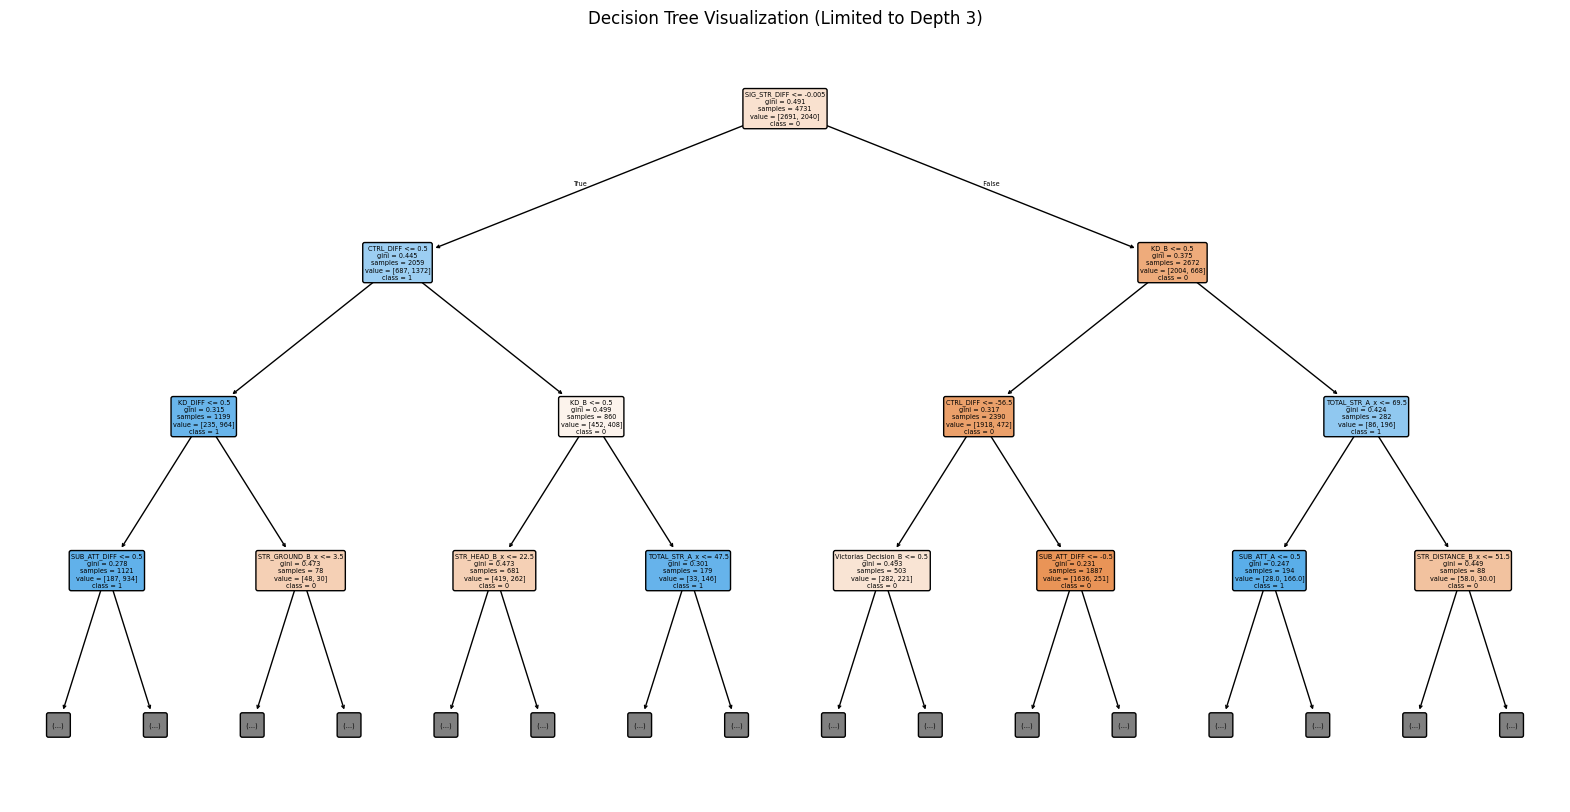

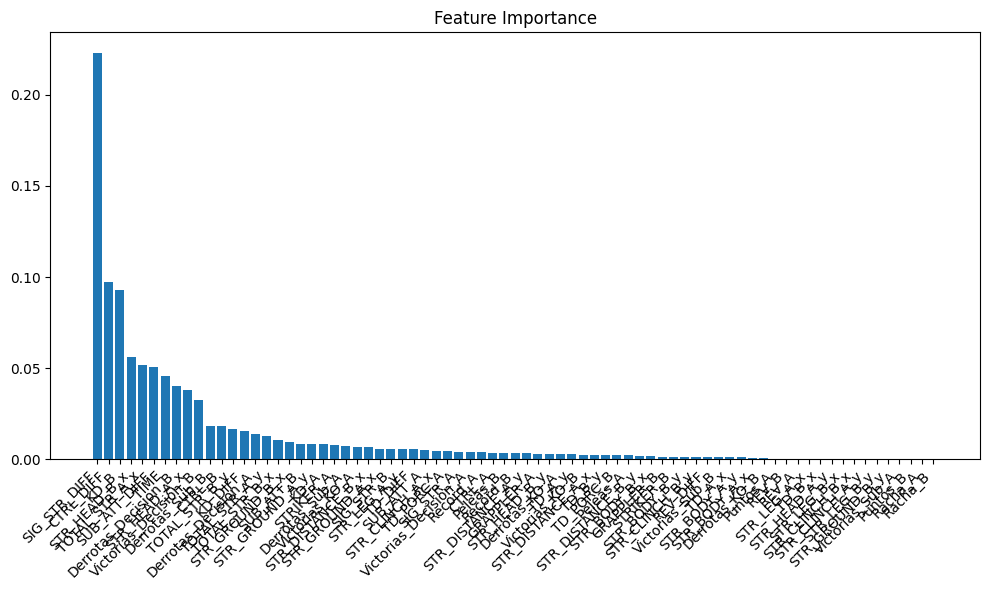


Top 10 Most Important Features:
                 feature  importance
46          SIG_STR_DIFF    0.223065
50             CTRL_DIFF    0.097282
2                   KD_B    0.092850
23          STR_HEAD_B_x    0.055914
13         TOTAL_STR_A_x    0.051618
48          SUB_ATT_DIFF    0.050703
0                   TIME    0.045909
74   Derrotas_Decision_B    0.040074
21          STR_HEAD_A_x    0.038003
68  Victorias_Decision_B    0.032410


In [ ]:
# Crear el modelo con los mejores hiperparámetros encontrados
mejor_arbol = DecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=13,
    random_state=42
)

# Entrenar el modelo
mejor_arbol.fit(X_train, y_train)